In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K


In [ ]:
pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.3 MB/s eta 0:00:00


In [ ]:
!pip install pyyaml h5py

In [ ]:
import tensorflow
import glob
from tensorflow.keras import backend as K
import random
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from google.colab.patches import cv2_imshow
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
import cv2
from PIL import Image
from keras import backend, optimizers
from tensorflow.keras import models, layers, regularizers




In [ ]:
path = glob.glob("/content/drive/MyDrive/imagesbinary/images binary 500/*.tif")
path.sort()

In [ ]:
train_images = []


for img_path in path:
  img = cv2.imread(img_path,1)
  img = cv2.resize(img, (256, 256),interpolation = cv2.INTER_NEAREST)
  train_images.append(img)

In [ ]:
x=cv2.imread("/content/drive/MyDrive/images binary 500/New folderimage_0_00.tif",1)

In [ ]:
max_value = np.max(x)


In [ ]:
max_value

211

In [ ]:
train_images

[]

In [ ]:
np.shape(train_images)

(0,)

In [ ]:
path1 = glob.glob("/content/drive/MyDrive/masksbinary500/*.tif")
path1.sort()

NameError: ignored

In [ ]:
train_masks = []
for img_path1 in path1:
  mask = cv2.imread(img_path1,0)
  mask = cv2.resize(mask, (256, 256), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
  train_masks.append(mask)

In [ ]:
np.shape(train_masks)

(500, 256, 256)

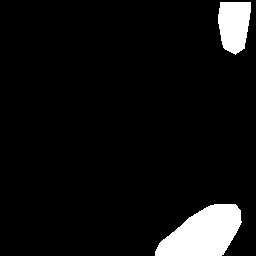

In [ ]:
cv2_imshow(train_masks[0])

In [ ]:
train_images = np.array(train_images)

train_masks = np.array(train_masks)
np.unique(train_masks)

array([  0, 255], dtype=uint8)

In [ ]:
#Normalize images
train_images = np.array(train_images)/255.
#D not normalize masks, just rescale to 0 to 1.
train_masks = np.expand_dims((np.array(train_masks)),3) /255.


In [ ]:
np.unique(train_masks)

array([0., 1.])

In [ ]:
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks, test_size = 0.10, random_state = 0)

#Further split training data to smaller subset for quick testing of models
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size = 0.20, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled



Class values in the dataset are ...  [0. 1.]


In [ ]:
np.shape(y_val)

(90, 256, 256, 1)

In [ ]:
np.shape(X_train)

(360, 256, 256, 3)

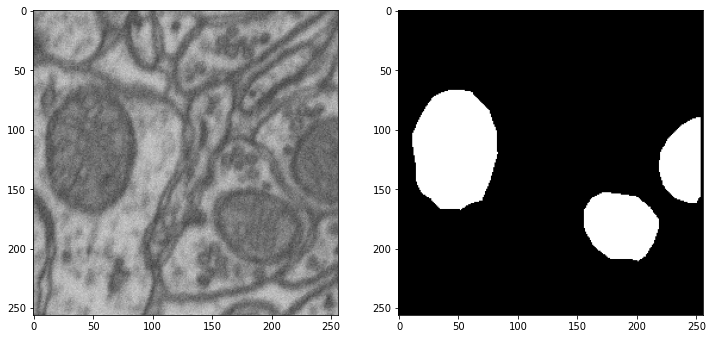

In [ ]:
#Sanity check, view few mages

image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256,3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

#######################################

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 32


In [ ]:
'''
Useful blocks to build Unet
conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)
'''

def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [ ]:

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


In [ ]:

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32


    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn



In [ ]:

def Attention_UNet(input_shape, NUM_CLASSES=3, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet,

    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate*1, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate*1, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate*2, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate*2, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate*3, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate*2, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate*2, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate*1, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate*1, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model


In [ ]:
import segmentation_models as sm
loss_fun= sm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0, class_indexes=None)

In [ ]:
# input_shape = (256,256,3)

In [ ]:
model = Attention_UNet(input_shape, NUM_CLASSES=3, dropout_rate=0.1, batch_norm=True)
model.compile(optimizer='adam', loss=loss_fun, metrics=[sm.metrics.IOUScore(threshold=0.5),
                                                        sm.metrics.FScore(threshold=0.5)])
model.summary()


In [ ]:
att_unet_model = Attention_UNet(input_shape)

att_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2),
              metrics=[sm.metrics.IOUScore(threshold=0.5),
                       sm.metrics.FScore(threshold=0.5)])


print(att_unet_model.summary())
start2 = datetime.now()
att_unet_history = att_unet_model.fit(X_train, y_train,
                    verbose=1,
                    batch_size = 16,
                    validation_data=(X_test, y_test ),
                    shuffle=False,
                    epochs=50)
stop2 = datetime.now()
#Execution time of the model
execution_time_Att_Unet = stop2-start2
print("Attention UNet execution time is: ", execution_time_Att_Unet)


Model: "Attention_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_77 (Conv2D)             (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_65 (BatchN  (None, 256, 256, 64  256        ['conv2d_77[0][0]']              
 ormalization)                  )                                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 activation_75 (Activation)     (None, 32, 32, 512)  0           ['batch_normalization_71[0][0]'] 
                                                                                                  
 conv2d_84 (Conv2D)             (None, 32, 32, 512)  2359808     ['activation_75[0][0]']          
                                                                                                  
 batch_normalization_72 (BatchN  (None, 32, 32, 512)  2048       ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 32, 32, 512)  0           ['batch_normalization_72[0][0]'] 
                                                                                                  
 max_pooli

In [ ]:
# # #____________________________________________
# # '''
# # Attention UNet
# # '''
# # att_unet_model = Attention_UNet(input_shape)

# # att_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2),
# #               metrics=['accuracy', jacard_coef])


# # print(att_unet_model.summary())
# start2 = datetime.now()
# att_unet_history = model.fit(X_train, y_train,
#                     verbose=1,
#                     batch_size = 16,
#                     validation_data=(X_val, y_val ),
#                     shuffle=False,
#                     epochs=50)
# stop2 = datetime.now()
# #Execution time of the model
# execution_time_Att_Unet = stop2-start2
# print("Attention UNet execution time is: ", execution_time_Att_Unet)

# # att_unet_model.save('mitochondria_Attention_UNet_50epochs_B_focal.hdf5')


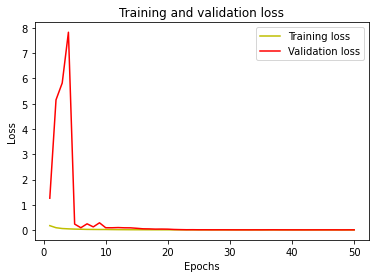

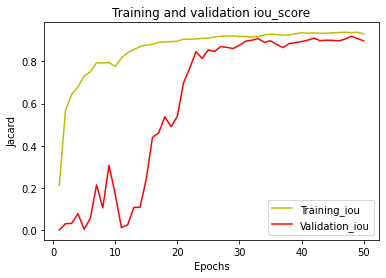

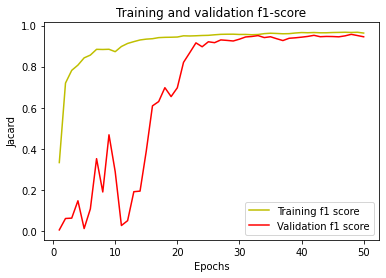

In [ ]:
loss = att_unet_history.history['loss']
val_loss = att_unet_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = att_unet_history.history['iou_score']
#acc = history.history['accuracy']
val_acc = att_unet_history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training_iou')
plt.plot(epochs, val_acc, 'r', label='Validation_iou')
plt.title('Training and validation iou_score')
plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()




acc = att_unet_history.history['f1-score']
#acc = history.history['accuracy']
val_acc = att_unet_history.history['val_f1-score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training f1 score')
plt.plot(epochs, val_acc, 'r', label='Validation f1 score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()

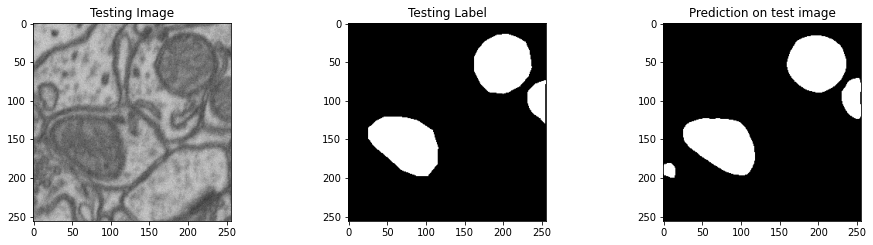

In [ ]:

import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (att_unet_model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU for all test images and average

import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (att_unet_model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)



df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)



Mean IoU = 0.38524473
0.95382905
0.9091566
0.94056344
0.95982385
0.90679014
0.93598455
1.0
0.9154843
0.93024445
0.84786755
0.9583746
0.9589552
0.9634485
0.94904685
0.93296075
0.9528923
0.6280646
0.9361493
0.9086771
0.94875044
0.9519948
0.9529754
0.9560637
0.94728136
0.91644454
0.6565068
0.9516901
0.9554447
0.94524187
0.9642886
0.9172698
0.9059186
1.0
0.95682263
0.969743
0.90121686
0.9444176
0.9476304
0.9299535
0.94707847
0.9453316
0.8364035
0.9029377
0.946291
0.54002166
0.8276845
0.9427105
0.95528793
0.94047266
0.9571732
Mean IoU is:  [0.91352826]


In [ ]:

def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    UNet,

    '''
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters


    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers

    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7

    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8

    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9

    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

In [ ]:
pip install focal_loss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Focal loss helps focus more on tough to segment classes.
from focal_loss import BinaryFocalLoss



In [ ]:
input_shape

(256, 256, 3)

In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:

unet_model = UNet(input_shape)
unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2),
              metrics=[sm.metrics.IOUScore(threshold=0.5),
                       sm.metrics.FScore(threshold=0.5)])



Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 256, 256, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
print(unet_model.summary())

In [ ]:
start1 = datetime.now()
unet_history = unet_model.fit(X_train, y_train,
                    verbose=1,
                    batch_size = 16,
                    validation_data=(X_test, y_test ),
                    shuffle=False,
                    epochs=50)

stop1 = datetime.now()
#Execution time of the model
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)


Epoch 1/50
23/23 [==============================] - 41s 1s/step - loss: 0.1662 - iou_score: 0.2013 - f1-score: 0.3219 - val_loss: 1.2125 - val_iou_score: 3.0896e-10 - val_f1-score: 3.0896e-10
Epoch 2/50
23/23 [==============================] - 21s 902ms/step - loss: 0.0976 - iou_score: 0.5012 - f1-score: 0.6621 - val_loss: 14.7414 - val_iou_score: 0.0785 - val_f1-score: 0.1453
Epoch 3/50
23/23 [==============================] - 21s 918ms/step - loss: 0.0600 - iou_score: 0.6278 - f1-score: 0.7697 - val_loss: 14.9056 - val_iou_score: 0.0786 - val_f1-score: 0.1455
Epoch 4/50
23/23 [==============================] - 21s 899ms/step - loss: 0.0487 - iou_score: 0.6475 - f1-score: 0.7848 - val_loss: 14.9026 - val_iou_score: 0.0786 - val_f1-score: 0.1455
Epoch 5/50
23/23 [==============================] - 21s 895ms/step - loss: 0.0403 - iou_score: 0.6701 - f1-score: 0.8008 - val_loss: 14.5477 - val_iou_score: 0.0787 - val_f1-score: 0.1456
Epoch 6/50
23/23 [==============================] - 21s 

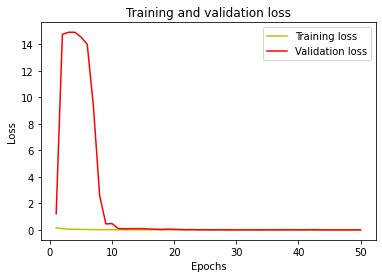

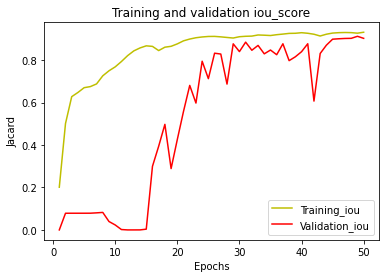

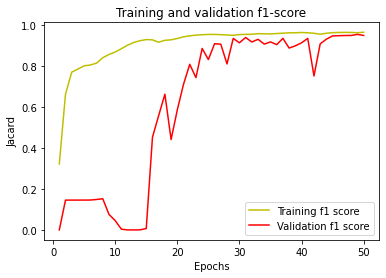

In [ ]:
loss =unet_history.history['loss']
val_loss = unet_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = unet_history.history['iou_score']
#acc = history.history['accuracy']
val_acc = unet_history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training_iou')
plt.plot(epochs, val_acc, 'r', label='Validation_iou')
plt.title('Training and validation iou_score')
plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()




acc = unet_history.history['f1-score']
#acc = history.history['accuracy']
val_acc = unet_history.history['val_f1-score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training f1 score')
plt.plot(epochs, val_acc, 'r', label='Validation f1 score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()

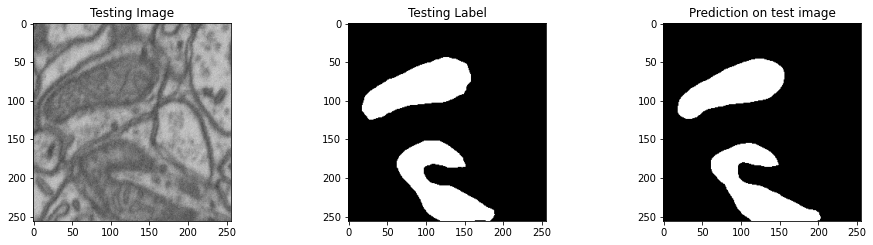

In [ ]:

import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (unet_model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU for all test images and average

import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (unet_model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)



df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)



Mean IoU = 0.43107605
0.95171595
0.94501036
0.9535483
0.9656396
0.9359913
0.9579765
1.0
0.96866536
0.956154
0.84981287
0.9491755
0.93741983
0.9350362
0.95019925
0.9266449
0.9130633
0.8679304
0.95323557
0.94616854
0.95084405
0.9557949
0.96994305
0.95166075
0.9669224
0.8793923
0.74157214
0.9475883
0.9653928
0.96755517
0.92305
0.90631723
0.96729875
1.0
0.94148874
0.942992
0.80166996
0.94756866
0.96870255
0.90243244
0.9453994
0.9584261
0.8881401
0.8887422
0.91719955
0.49975586
0.9039041
0.9423852
0.96296144
0.9326061
0.9593214
Mean IoU is:  [0.92209196]


In [ ]:

att_unet_model.save('mitochondria_Attention_UNet_50epochs_B_focal.hdf5')

In [ ]:
np.shape(X_test)

(12, 256, 256, 1)

In [ ]:
log_csv = CSVLogger('/content/drive/MyDrive/my_logs.csv', separator=',', append=True)
early_stop = EarlyStopping(monitor='val_dice_coef', patience=3, verbose=1)
file_path = '/content/drive/MyDrive/0_epoch_weights/epochno-{epoch:04d}.hdf5'
checkpoint = ModelCheckpoint(file_path, verbose=1,monitor="val_dice_coef", save_best_only=True, mode='max',save_freq=1)


tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='/content/drive/MyDrive/0ten/Tensorboard_logs',
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None,
)

callbacks_list = [log_csv,checkpoint,tensorboard_callback,early_stop]

In [ ]:
np.shape(X_test)

(12, 256, 256, 1)

In [ ]:
# from keras.models import load_model

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/0_epoch_weights/epochno-0003.hdf5',custom_objects={'focal_loss':loss_fun,
                                                                                 'iou_score':sm.metrics.IOUScore(threshold=0.5),
                                                                                 "jacard_coef":jacard_coef,
                                                                                 "dice_coef":dice_coef,
                                                                                 'f1-score':sm.metrics.FScore(threshold=0.5)})


In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)


In [ ]:
y_pred

In [ ]:
# Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()



IndexError: ignored

In [ ]:
history = model.fit(X_train,y_train_cat,
                    batch_size = 8,
                    verbose=1,
                    epochs=20,
                    validation_data=(X_val,y_val_cat),
                    callbacks=[callbacks_list],
                    shuffle=False)

In [ ]:
model.save("/content/drive/MyDrive/0_epoch_weights/ayush.h5")

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

NameError: ignored

In [ ]:
img = model.predict(X_test)

In [ ]:
y_pred_argmax=np.argmax(img, axis=3)


In [ ]:
# Predict on a few images
#model = get_model()
model.load_weights('/content/drive/MyDrive/0_epoch_weights/ayush.h5')
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0],cmap='jet')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0],cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap="jet")
plt.show()



In [ ]:
tf.model.save("/content/drive/MyDrive/0_epoch_weights/model.h5")

In [ ]:
# model.fit(x_train, y_train, initial_epoch=9, epochs=19, callbacks=[Tensorboard()]

In [ ]:
from keras.models import load_model
model1 = load_model('/content/drive/MyDrive/0_epoch_weights/epoch_100focal_loss_iouscore_dropout_random.h5',custom_objects={'focal_loss':loss_fun,
                                                                                 'iou_score':sm.metrics.IOUScore(),
                                                                                #  "jacard_coef":jacard_coef,
                                                                                #  "dice_coef":dice_coef,
                                                                                 'f1-score':sm.metrics.FScore()})
